In [0]:
import numpy as np
import matplotlib.pyplot as plt
# Import some useful packages
import tensorflow as tf
import tensorflow.keras.backend as K

# Layers for FNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate, BatchNormalization, Add, ReLU
from tensorflow.keras.layers import Dense

# Optimizers for training
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

# Losses for training
from tensorflow.keras import losses

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

In [0]:
#載入和標準化資料
# Load dataset
(X_train, y_train0), (X_test, y_test0) = datasets.fashion_mnist.load_data()

# Reshape size
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Normalize the range of featurs
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

In [0]:
#定義抽樣函數
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [0]:
#encode
enc_1 = Dense(512, activation='sigmoid')
enc_2 = Dense(128, activation='sigmoid')
enc_3 = Dense(32, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_3 = Dense(32, activation='sigmoid')
dec_2 = Dense(128, activation='sigmoid')
dec_1 = Dense(512, activation='sigmoid')
dec_0 = Dense(784, activation='sigmoid')
x = Input(shape=(784,))
enc_1_x = enc_1(x)
enc_2_x = enc_2(enc_1_x)
enc_3_x = enc_3(enc_2_x)

z_mean = enc_mean(enc_3_x)
z_log_var = enc_log_var(enc_3_x)



In [22]:
#decode
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
z_input = Input(shape=(2,))
x_hat = dec_0(dec_1(dec_2(dec_3(z_input))))
x_hat = dec_0(dec_1(dec_2(dec_3(z))))

VAE = Model(x, x_hat)
VAE.summary()

VAE_Decoder = Model(z_input, dec_0(dec_1(dec_2(dec_3(z_input)))))
VAE_Decoder.summary()
#encode
VAE_Encoder = Model(x, z)
VAE_Encoder.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 512)          401920      input_6[0][0]                    
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 128)          65664       dense_27[0][0]                   
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 32)           4128        dense_28[0][0]                   
____________________________________________________________________________________________

In [0]:
#loss函數
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

In [13]:
VAE.compile(optimizer=Adam())
VAE.fit(X_train, X_train, batch_size=784, epochs=50)

Epoch 1/50
77/77 [==============================] - 6s 77ms/step - loss: 34.7893
Epoch 2/50
77/77 [==============================] - 6s 78ms/step - loss: 34.2074
Epoch 3/50
77/77 [==============================] - 6s 77ms/step - loss: 33.9701
Epoch 4/50
77/77 [==============================] - 6s 77ms/step - loss: 33.7927
Epoch 5/50
77/77 [==============================] - 6s 77ms/step - loss: 33.7076
Epoch 6/50
77/77 [==============================] - 6s 77ms/step - loss: 33.5551
Epoch 7/50
77/77 [==============================] - 6s 78ms/step - loss: 33.3703
Epoch 8/50
77/77 [==============================] - 6s 77ms/step - loss: 33.3013
Epoch 9/50
77/77 [==============================] - 6s 78ms/step - loss: 33.1193
Epoch 10/50
77/77 [==============================] - 6s 78ms/step - loss: 32.8497
Epoch 11/50
77/77 [==============================] - 6s 77ms/step - loss: 33.0360
Epoch 12/50
77/77 [==============================] - 6s 78ms/step - loss: 32.8275
Epoch 13/50
77/77 [======

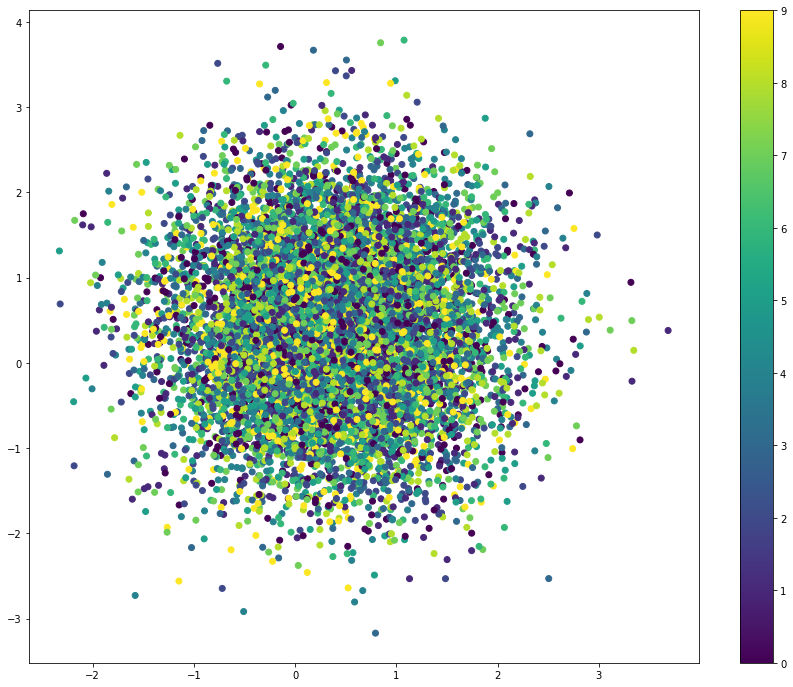

In [19]:
#視覺化呈現
indices = np.random.randint(X_train.shape[0], size=10000)
VAE_latents = VAE_Encoder.predict(X_train[indices])
plt.figure(figsize=(15, 12))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='viridis')
plt.colorbar()
plt.show()

In [0]:
#decode
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [0]:
n = 18
digit_size = 28

grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

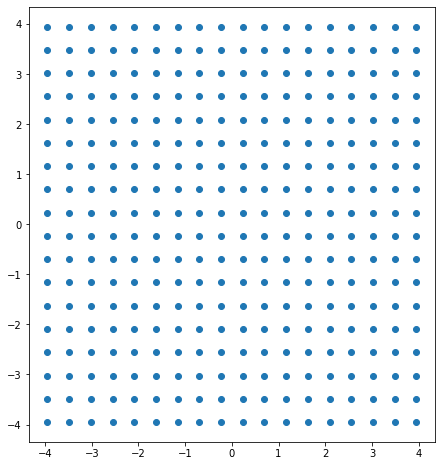

In [32]:
plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)
